<a href="https://colab.research.google.com/github/matt700395/RL_1st/blob/master/lunarlander_dqn_ver_korea_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 86, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninst

In [ ]:
!pip install tensorflow==1.15 # 1.15 버전 Tensorflow 설치

In [1]:
# see: colab.research.google.com/drive/1GLlB53gvZaUyqMYv8GmZQJmshRUzV_tg
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip install stable-baselines==2.7.0

# box2d fork until SWIG dependency is replaced
!pip install box2d-py

# pyglet later versions break gym apparently
!pip install pyglet==1.3.2

!pip install gym pyvirtualdisplay

# Set up display; otherwise rendering will fail for
# classic control type envs, apparently
import os
import Box2D
import pyglet
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'


# See https://github.com/ipython/ipython/issues/10045#issuecomment-522697219
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
     |████████████████████████████████| 259 kB 13.8 MB/s 
     |████████████████████████████████| 2.5 MB 66.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185295 sha256=1c370ef1b8bb0fc195de715a25e9d2936478535729905d1253e240d64f59ad0d
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 448 kB 14.0 MB/s 
     |████████████████████████████████| 1.0 MB 13.2 MB/s 
  Attempting uninstall: pyglet
    Found existing i

In [2]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from pyvirtualdisplay import Display


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        #self.batch_size = 32
        #self.train_start = 1000
        self.batch_size = 5
        self.train_start = 5

        # 리플레이 메모리, 최대 크기 2000
        #self.memory = deque(maxlen=20000)
        self.memory = deque(maxlen=100)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()

        # 타깃 모델 초기화
        self.update_target_model()


    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(30, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)



In [17]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import random
import gym

display = Display(visible=False, size=(400, 300))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 30)                270       
                                                                 
 dense_31 (Dense)            (None, 30)                930       
                                                                 
 dense_32 (Dense)            (None, 4)                 124       
                                                                 
Total params: 1,324
Trainable params: 1,324
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 30)                270       
                                                                 
 dense_34 (Dense)           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0   score: -7.730431052963894   memory length: 63   epsilon: 0.9426789411643326


episode: 1   score: -60.218357816638445   memory length: 100   epsilon: 0.8658253647948594
episode: 2   score: -308.8812691665953   memory length: 100   epsilon: 0.7609888362515699
episode: 3   score: -247.36121587235766   memory length: 100   epsilon: 0.6954601118039707


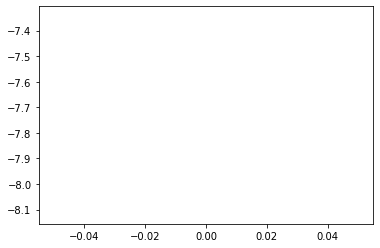

In [19]:
#EPISODES = 300
EPISODES = 3

# CartPole-v1 환경, 최대 타임스텝 수가 500
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)

scores, episodes = [], []

done_cnt = 0

for e in range(EPISODES+1):
    done = False
    score = 0
    cnt = 0
    # env 초기화
    state = env.reset() #== obs
    state = np.reshape(state, [1, state_size])
    img = env.render(mode='rgb_array')
    n_images = 100
    images = []

    while not done:
      images.append(img)
      if agent.render:
        env.render()


      # 현재 상태로 행동을 선택
      action = agent.get_action(state)
      # 선택한 행동으로 환경에서 한 타임스텝 진행
      next_state, reward, done, position = env.step(action)
      next_state = np.reshape(next_state, [1, state_size])
      # 에피소드가 중간에 끝나면 -100 보상
      reward = reward if not done or score == 499 else -100

      img = env.render(mode='rgb_array')

      #print(f'no edit reward : {reward}')
      # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
      agent.append_sample(state, action, reward, next_state, done)
      # 매 타임스텝마다 학습
      if len(agent.memory) >= agent.train_start:
          agent.train_model()

      score += reward
      state = next_state
      #print(f'score : {score}, reward : {reward}')
      if done:
          reward += 10

          # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
          agent.update_target_model()

          score = score if score == 500 else score + 100
          # 에피소드마다 학습 결과 출력
          scores.append(score)
          episodes.append(e)
          print("episode:", e, "  score:", score, "  memory length:",
                len(agent.memory), "  epsilon:", agent.epsilon)

          # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
          if np.mean(scores[-min(10, len(scores)):]) > 490:
              agent.model.save_weights("./lunar_lander_v2.h5")
              sys.exit()
    imageio.mimwrite('./lander.gif',[np.array(img) for i, img in enumerate(images) if i%2 == 0],fps=29)

    if e % 100 == 0:
      agent.model.save_weights("./lunar_lander_v2.h5")
      pylab.plot(episodes, scores, 'b')
      pylab.savefig("./lunar_lander_v2.png")

    

In [19]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import random
import gym

display = Display(visible=False, size=(400, 300))
display.start()

In [6]:
import imageio
import numpy as np

# Number of images to capture
n_images = 1200

images = []

# init a new episode
obs = env.reset()
# init the img var with the starting state of the env
img = env.render(mode='rgb_array')

for i in range(n_images):
  # At each step, append an image to list
  images.append(img)

  # Advance a step and render a new image
  action, _ = predict(obs)
  obs, _, _ ,_ = env.step(action)
  img = env.render(mode='rgb_array')

imageio.mimwrite('./lander.gif',
                [np.array(img) for i, img in enumerate(images) if i%2 == 0],
                fps=29)

NameError: ignored